In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 16:35:51 2020

@author: u300737
"""
import os
import sys

import numpy as np
import pandas as pd
import xarray as xr

start_path=os.getcwd()
plot_path=start_path+"/../plots/"
ac3_scripts_path=start_path+"/../scripts/"
my_git_path=start_path+"/../../"
major_work_path=my_git_path+"/../Work/GIT_Repository/"
synth_ar_path=my_git_path+"/Synthetic_Airborne_Arctic_ARs/"
hamp_processing_path=my_git_path+"/hamp_processing_python/"
config_path=synth_ar_path+"config/"
sys.path.insert(1,config_path)
sys.path.insert(2,ac3_scripts_path)
sys.path.insert(3,start_path+"/../src/")
sys.path.insert(4,synth_ar_path+"/src/")
sys.path.insert(5,synth_ar_path+"/plotting/")
sys.path.insert(6,hamp_processing_path)
sys.path.insert(7,hamp_processing_path+"/plotting/")
import data_config
###############################################################################
import flightcampaign
import moisturebudget as Budgets
###############################################################################
#Grid Data
from reanalysis import ERA5,CARRA
from ICON import ICON_NWP as ICON
import gridonhalo as Grid_on_HALO
###############################################################################
#-----------------------------------------------------------------------------#
import warnings
warnings.filterwarnings("ignore")

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

C:\Users\u300737\AppData\Local\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Plotting routines

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import seaborn as sns


from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.colors import LightSource
from cmcrameri import cm as cmaeri


def map_precipitation_region(hydro_ds,processed_radar,halo_df,sector_radar_rain,plot_path,sector="warm"):
    
    
    precip_map=plt.figure(figsize=(12,12))

    if flight[0]=="RF05":
        central_lat=70
        central_lon=-10
    elif flight[0]=="RF06":
        central_lat=74
        central_lon=15
    time_step=0
    print(hydro_ds.time[time_step])
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    ax1 = plt.subplot(2,2,1,projection=ccrs.AzimuthalEquidistant(
                                central_longitude=central_lon,
                                central_latitude=central_lat))
    # IVT convergence as background based on ERA5
    C1=ax1.scatter(np.rad2deg(hydro_ds["clon"]),
            np.rad2deg(hydro_ds.clat),c=hydro_ds["hourly_prec"][time_step,:],
            cmap="GnBu",s=0.5,vmin=0.0,vmax=1,
            transform=ccrs.PlateCarree())
    cbar=plt.colorbar(C1,ax=ax1)
    cbar.set_label("Precipitation / $\mathrm{mm\,h}^{-1}$")
    ax1.set_extent([halo_df["longitude"].min()-2,halo_df["longitude"].max()+2,
                halo_df["latitude"].min()-2,halo_df["latitude"].max()+2])
    if sector!="":
        # cut the halo for the rectangle just to the specific sector
        halo_df=halo_df.loc[sector_radar_rain.index]
    if sector=="warm":
        halo_color="orange"
    else:
        halo_color="purple"
    
    ax1.plot([halo_df["longitude"].min(),halo_df["longitude"].min(),
          halo_df["longitude"].max(),halo_df["longitude"].max(),
          halo_df["longitude"].min()],
          [halo_df["latitude"].min(),halo_df["latitude"].max(),
          halo_df["latitude"].max(),halo_df["latitude"].min(),
          halo_df["latitude"].min()],
          lw=3,ls="-",color="white",
          transform=ccrs.PlateCarree(),zorder=3)
    
    ax1.plot([halo_df["longitude"].min(),halo_df["longitude"].min(),
          halo_df["longitude"].max(),halo_df["longitude"].max(),
          halo_df["longitude"].min()],
          [halo_df["latitude"].min(),halo_df["latitude"].max(),
          halo_df["latitude"].max(),halo_df["latitude"].min(),
          halo_df["latitude"].min()],
          lw=2,ls="--",color=halo_color,
          transform=ccrs.PlateCarree(),zorder=3)
    
    ax1.scatter(sector_radar_rain["lon"],sector_radar_rain["lat"],color="darkgrey",s=40,transform=ccrs.PlateCarree(),zorder=5)
    ax1.scatter(sector_radar_rain["lon"],sector_radar_rain["lat"],
                c=sector_radar_rain["rate"],cmap="GnBu",s=15,vmin=0.0,vmax=1,transform=ccrs.PlateCarree(),zorder=6)
    ax1.coastlines(resolution="50m")
    gl1=ax1.gridlines(draw_labels=True,dms=True,
                          x_inline=False,y_inline=False)
    gl1.xlabels_top = False
    gl1.ylabels_right = False
    ax1.plot(processed_radar["lon"],processed_radar["lat"],color="k",ls="--",lw=1,transform=ccrs.PlateCarree())
    fig_name="Map_box_precipitation"
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_"+fig_name
    fig_path=plot_path
    sns.despine(offset=1)
    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as ",fig_path+fig_name)

def quicklook_sector(radar_rain,sector="warm"):
    if sector=="warm":
        halo_color="orange"
    else:
        halo_color="purple"
    plt.scatter(radar_rain["lon"],radar_rain["lat"],color=halo_color)
    #cold_icon_rain=halo_icon_hmp.loc[cold_radar_rain.index]
    #cold_icon_rain["rate"]=cold_icon_rain["Interp_Precip"]
    
    #plt.scatter(cold_radar_rain["lon"],cold_radar_rain["lat"],color="purple")
    #warm_icon_rain
    
def boxplot_precip_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                              plot_path=os.getcwd()+"/../plots/"):
    # statistics only refer to cases when it precipitates: conditional statistics
    # Organise data
    x1 = precip_icon_series.copy()
    x1 = x1[x1>0]
    x1 = x1.dropna()
    x1.index=range(len(x1))
    x2 = halo_icon_hmp["Interp_Precip"]
    x2 = x2[x2>0]
    x2.index=range(len(x2))
    x3 = halo_era5["Interp_Precip"]
    x3 = x3[x3>0]
    x3.index = range(len(x3))
    x4 = radar_precip_rate["rate"]
    x4 = x4[x4>0]
    x4.index = range(len(x4))

    x_appended=pd.DataFrame(data=np.nan,columns=["Rates","Data","No"],
                       index=x1.index)
    x_appended["Rates"]=x1.values.astype(float)
    x_appended["Data"] ="ICON_AR_Region"
    x_appended["No"]   = 1

    x2_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x2.index)
    x2_append["Rates"]=x2.values
    x2_append["Data"] ="ICON_HALO_Track"
    x2_append["No"]  =2

    x3_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x3.index)
    x3_append["Rates"]=x3.values
    x3_append["Data"] ="ERA5_HALO_Track"
    x3_append["No"]   =3

    x4_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],
                       index=x4.index)
    x4_append["Rates"]=x4.values
    x4_append["Data"] ="Radar_HALO_Track"
    x4_append["No"]   =4

    x_appended=x_appended.append(x2_append,ignore_index=True)
    x_appended=x_appended.append(x3_append,ignore_index=True)
    x_appended=x_appended.append(x4_append,ignore_index=True)
    x_to_plot=x_appended.copy()#iloc[0:1000,:]
    del x_to_plot["Data"]
    print("Create boxplot")

    boxpl=sns.boxplot(x=np.log10(x_to_plot["Rates"]),
            y=x_to_plot["No"],palette={1:"dodgerblue",2:"orange",3:"deeppink",4:"k"},
            orient="h")
    boxpl.set_xlim([-5,1])
    boxpl.set_yticks([0,1,2,3],["ICON AR","ICON \nHALO Track","ERA5 \nHALO Track","Radar \n HALO Track"])
    fig_name="Boxplot_Precip_representativeness.png"
    plt.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)

def rain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                                 flight,ar_of_day,sector_to_plot,
                                conditional_dist=False):
    import seaborn as sns
    sns.set_style("white")

    x1 = precip_icon_series.copy()
    x2 = halo_icon_hmp["Interp_Precip"]
    x3 = halo_era5["Interp_Precip"]
    x4 = radar_precip_rate["rate"]
    
    if conditional_dist:
        x1=x1[x1>0]
        x2=x2[x2>0]
        x3=x3[x3>0]
        x4=x4[x4>0]
    # Plot
    kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})

    plt.figure(figsize=(10,7), dpi= 300)#
    sns.distplot(x3, bins=np.linspace(0,2,91),color="deeppink", label="ERA5 HALO Track", **kwargs)
    sns.distplot(x1, bins=np.linspace(0,2,91),color="dodgerblue", label="ICON AR region", **kwargs)
    sns.distplot(x2, bins=np.linspace(0,2,91),color="orange", label="ICON HALO Track", **kwargs)
    sns.distplot(x4, bins=np.linspace(0,2,91),color="k", label="Radar HALO Track", **kwargs)
    plt.ylim(0,50)
    plt.xlim(0,1)
    if not conditional_dist:
        plt.xlabel("Precipitation rate / $\mathrm{mmh}^{-1}$")
    else:
        plt.xlabel("Conditional Precipitation rate / $\mathrm{mmh}^{-1}$")
    
    plt.legend()
    fig_name="Rain_rate_representativeness.png"
    if conditional_dist:
        fig_name="Conditional_"+fig_name
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_"+fig_name
    fig_path=plot_path
    sns.despine(offset=1)
    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as ",fig_path+fig_name)
    
def plot_frontal_sector_radar_icon_rain_comparison(warm_radar_rain,cold_radar_rain,
                                                   warm_icon_rain,cold_icon_rain,
                                                  plot_path,do_conditional=False):
    matplotlib.rcParams.update({"font.size":18})
    # Preprocess the data
    radar_str="processed_radar"
    x1=warm_radar_rain["rate"]
    x2=warm_icon_rain["rate"]
    x3=cold_radar_rain["rate"]
    x4=cold_icon_rain["rate"]
    mean_term="mean:"
    if do_conditional:
        x1=x1.loc[x1>0.001]
        x2=x2.loc[x2>0.0]
        x3=x3.loc[x3>0.001]
        x4=x4.loc[x4>0.0]
        mean_term="cond. "+mean_term
    x1.index=range(len(x1))
    x2.index=range(len(x2))
    x3.index = range(len(x3))
    x4.index = range(len(x4))

    x_appended=pd.DataFrame(data=np.nan,columns=["Rates","Data","No"],index=x1.index)
    x_appended["Rates"]=x1.values.astype(float)
    x_appended["Data"] ="Pre-frontal Radar"
    x_appended["No"]   = 1

    x2_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],index=x2.index)
    x2_append["Rates"]=x2.values
    x2_append["Data"] ="Pre-frontal ICON"
    x2_append["No"]  =3

    x3_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],index=x3.index)
    x3_append["Rates"]=x3.values
    x3_append["Data"] ="Post-frontal Radar"
    x3_append["No"]   =2

    x4_append=pd.DataFrame(data=np.nan,columns=["Rates","Data"],index=x4.index)
    x4_append["Rates"]=x4.values
    x4_append["Data"] ="Post-frontal ICON"
    x4_append["No"]   =4

    x_appended=x_appended.append(x2_append,ignore_index=True)
    x_appended=x_appended.append(x3_append,ignore_index=True)
    x_appended=x_appended.append(x4_append,ignore_index=True)

    x_to_plot=x_appended.copy()

    del x_to_plot["Data"]
    print("Create boxplot")

    fig=plt.figure(figsize=(16,7))
    boxpl=sns.boxplot(x=x_to_plot["Rates"],
            y=x_to_plot["No"],linewidth=3,
            orient="h",palette=["darkorange","darkviolet","bisque","plum"])#,colours=["darkorange","orange","darkviolet","mediumorchid"])
    boxpl.spines['left'].set_linewidth(3)
    boxpl.spines['bottom'].set_linewidth(3)
    boxpl.text(0.5,-.25,s="cond. mean:"+str(np.round(x1.mean(),2))+"$\mathrm{mmh}^{-1}$")
    boxpl.text(0.5,.75,s="cond. mean:"+str(np.round(x3.mean(),2))+"$\mathrm{mmh}^{-1}$")
    boxpl.text(0.5,1.75,s="cond. mean:"+str(np.round(x2.mean(),2))+"$\mathrm{mmh}^{-1}$")
    boxpl.text(0.5,2.75,s="cond. mean:"+str(np.round(x4.mean(),2))+"$\mathrm{mmh}^{-1}$")

    boxpl.set_xlim([0,1])
    boxpl.set_xticks([0,.25,.5,.75,1])
    boxpl.set_yticklabels(["Radar \npre-frontal","Radar \npost-frontal","ICON \npre-frontal","ICON \npost-frontal"])
    #boxpl.xaxis.xtick_params({"length":2,"width":3})
    boxpl.set_ylabel("")
    if not do_conditional:
        boxpl.set_xlabel("Precipitation Rates ($\mathrm{mm h}^{-1}$)")
    else:
        boxpl.set_xlabel("Conditional Precipitation Rates ($\mathrm{mm h}^{-1}$)")
    sns.despine(ax=boxpl,offset=10)
    if calibrated_radar: radar_str="calibrated_and_"+radar_str
    fig_name="Rain_rate_Statistics_"+flight[0]+"_"+sector_to_plot+"_"+radar_str+"_"+reflectivity_for_snow+".png"
    if do_conditional:
        fig_name="Conditional_"+fig_name
    fig.savefig(plot_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as:",plot_path+fig_name)
    
def sector_rain_halo_icon_comparison(warm_radar_rain,cold_radar_rain,
                                    warm_icon_rain,cold_icon_rain,
                                    flight,ar_of_day,sector_to_plot,
                                     plot_path):
    x1=warm_radar_rain["rate"]#.loc[warm_radar_rain["rate"]>0.001]
    x2=warm_icon_rain["rate"]#.loc[warm_icon_rain["rate"]>0.0]
    x3=cold_radar_rain["rate"]#.loc[cold_radar_rain["rate"]>0.001]
    x4=cold_icon_rain["rate"]#.loc[cold_icon_rain["rate"]>0.0]

    x1.index=range(len(x1))
    x2.index=range(len(x2))
    x3.index = range(len(x3))
    x4.index = range(len(x4))
    # creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(12,12))

    import seaborn as sns
    sns.set_style("white")
    import matplotlib
    matplotlib.rcParams.update({"font.size":22})
    # Plot
    kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})
    sns.distplot(x3, bins=np.linspace(0,2,91),color="darkorange", label="Pre-frontal radar",ax=ax_hist, **kwargs)
    sns.distplot(x1, bins=np.linspace(0,2,91),color="orange", label="Pre-frontal ICON",ax=ax_hist, **kwargs)
    sns.distplot(x2, bins=np.linspace(0,2,91),color="darkviolet", label="Post-frontal radar", ax=ax_hist, **kwargs)
    sns.distplot(x4, bins=np.linspace(0,2,91),color="mediumorchid", label="Post-frontal ICON", ax=ax_hist,**kwargs)
    plt.ylim(0,50)
    plt.xlim(0,1)
    plt.xlabel("Conditional Precipitation rate / $\mathrm{mmh}^{-1}$")
    plt.legend()
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_Conditional_Rain_rate_representativeness.png"
    fig_path=plot_path
    sns.despine(offset=1)
    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as ",fig_path+fig_name)

## Allocations, Switches, and Definitions

In [3]:
campaign="HALO_AC3"
ar_of_day="AR_entire_1"
flight=["RF05"]
reflectivity_for_snow="Z_g"
sector_to_plot="warm"
take_arbitary=True
do_plotting=False
calibrated_radar=True

from simplified_flight_leg_handling import simplified_run_grid_main
with HiddenPrints():
    halo_era5,halo_df,cmpgn_cls,ERA5_on_HALO,radar,Dropsondes=\
        simplified_run_grid_main(flight=flight,config_file_path=major_work_path,ar_of_day=ar_of_day)
flight=cmpgn_cls.flight

flight_dates={
    "RF03":"20220313",
    "RF05":"20220315",
    "RF06":"20220316",
    "RF16":"20220410"}

## reanalysis dataset (if needed load)

In [4]:
#Load config file
config_file=data_config.load_config_file(major_work_path,"data_config_file")

cmpgn_cls=flightcampaign.HALO_AC3(
                             is_flight_campaign=True,
                             major_path=config_file["Data_Paths"]["campaign_path"],
                             aircraft="HALO",interested_flights=[flight],
                             instruments=["radar","radiometer","sonde"])               

import reanalysis as Reanalysis
file_name="total_columns_"+cmpgn_cls.years[flight[0]]+"_"+\
                    cmpgn_cls.flight_month[flight[0]]+"_"+\
                    cmpgn_cls.flight_day[flight[0]]+".nc"    
        
era5=Reanalysis.ERA5(for_flight_campaign=True,campaign="HALO_AC3",
                  research_flights=flight,
                  era_path=cmpgn_cls.campaign_path+"/data/ERA-5/")
        
ds,era_path=era5.load_era5_data(file_name)
        
#IVT Processing
ds["IVT_v"]=ds["p72.162"]
ds["IVT_u"]=ds["p71.162"]
ds["IVT"]=np.sqrt(ds["IVT_u"]**2+ds["IVT_v"]**2)
ds["IVT_conv"]=ds["p84.162"]*3600 # units in seconds


C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini
Config-file C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository//data_config_file.ini.ini  already exists
Overall directory of campaign is:  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3


In [57]:
ds.isel({"time":12})

<xarray.Dataset>
Dimensions:    (longitude: 721, latitude: 161)
Coordinates:
  * longitude  (longitude) float32 -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... 50.5 50.25 50.0
    time       datetime64[ns] 2022-03-15T12:00:00
Data variables: (12/17)
    msl        (latitude, longitude) float32 ...
    siconc     (latitude, longitude) float32 ...
    sst        (latitude, longitude) float32 ...
    tciw       (latitude, longitude) float32 ...
    tclw       (latitude, longitude) float32 ...
    tcwv       (latitude, longitude) float32 ...
    ...         ...
    e          (latitude, longitude) float32 ...
    tp         (latitude, longitude) float32 ...
    IVT_v      (latitude, longitude) float32 -1.937 -1.937 ... -0.8792 -1.811
    IVT_u      (latitude, longitude) float32 -1.197 -1.197 ... 20.05 20.55
    IVT        (latitude, longitude) float32 2.277 2.277 2.277 ... 20.07 20.63
    IVT_conv   (latitude, longitude) float32 -0.3337 -0.3337 ... 0.1385 0.05262
Attributes:
    Conventions:  CF-1.6
    history:      2023-11-01 10:36:51 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [5]:
# ICON File
icon_major_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"
hydrometeor_icon_path=cmpgn_cls.campaign_path+"/data/ICON_LEM_2KM/"

icon_resolution=2000 # units m
upsample_time="20min"
date=flight_dates[flight[0]]
interp_icon_hmp_file=flight[0]+"_"+ar_of_day+"_"+"interpolated_HMP.csv"
icon_var_list=ICON.lookup_ICON_AR_period_data(cmpgn_cls.name,flight,ar_of_day,
                                                 icon_resolution,
                                                 hydrometeor_icon_path,
                                                 synthetic=False)

ICON_on_HALO=Grid_on_HALO.ICON_on_HALO(
    cmpgn_cls,icon_var_list,halo_df,flight,date,
    interpolated_hmp_file=interp_icon_hmp_file,
    interpolated_hmc_file=None,ar_of_day=ar_of_day,
    upsample_time=upsample_time,
    synthetic_icon=False,
    synthetic_flight=False)

if campaign=="HALO_AC3":
    hydrometeor_icon_path=hydrometeor_icon_path+flight[0]+"/"
ICON_on_HALO.update_ICON_hydrometeor_data_path(hydrometeor_icon_path)

halo_icon_hmp=ICON_on_HALO.load_interpolated_hmp()
#halo_icon_hmp.describe()

RF05_AR_entire_1_interpolated_HMP.csv  is already calculated and will be opened


## Flight leg and AR localisation

In [6]:
if flight[0]=="RF03":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-13 10:00","2022-03-13 10:35"]
            internal_times=["2022-03-13 10:37","2022-03-13 11:10"]
            outflow_times=["2022-03-13 11:16","2022-03-13 11:40"]
    
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-15 10:11","2022-03-15 11:13"]
            internal_times=["2022-03-15 11:18","2022-03-15 12:14"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-15 14:30","2022-03-15 15:25"]
            internal_times=["2022-03-15 13:20","2022-03-15 14:25"]
            outflow_times=["2022-03-15 12:20","2022-03-15 13:15"]
if flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-03-16 10:45","2022-03-16 11:21"]
            internal_times=["2022-03-16 11:25","2022-03-16 12:10"]
            outflow_times=["2022-03-16 12:15","2022-03-16 12:50"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]
if flight[0]=="RF16":
    if ar_of_day=="AR_entire_1":
            inflow_times=["2022-04-10 10:40","2022-04-10 11:08"]
            internal_times=["2022-04-10 11:10","2022-04-10 11:36"]
            outflow_times=["2022-04-10 11:57","2022-04-10 12:15"]
    elif ar_of_day=="AR_entire_2":
            inflow_times=["2022-03-16 12:12","2022-03-16 12:55"]
            internal_times=["2022-03-16 12:58","2022-03-16 13:40"]
            outflow_times=["2022-03-16 13:45","2022-03-16 14:18"]

new_halo_dict={flight[0]:{"inflow":halo_df.loc[inflow_times[0]:inflow_times[-1]],
                          "internal":halo_df.loc[internal_times[0]:internal_times[-1]],
                          "outflow":halo_df.loc[outflow_times[0]:outflow_times[-1]]}}

from atmospheric_rivers import Atmospheric_Rivers
AR_inflow,AR_outflow=Atmospheric_Rivers.locate_AR_cross_section_sectors(
                                    new_halo_dict,ERA5_on_HALO.halo_era5,
                                    flight[0])

relevant_sondes_dict={}
if take_arbitary:
    for sector in ["warm_sector","core","cold_sector"]:
        print("Analyse frontal sector ",sector)
        #add_sonde=1
        #if sector=="core":
        #    add_sonde=1
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]

Analyse frontal sector  warm_sector
Analyse frontal sector  core
Analyse frontal sector  cold_sector


## Radar dataset

In [7]:
# processing_path packages
import data_config
import measurement_instruments_ql
import quicklook_dicts

radar_dict={}
bahamas_dict={}  
campaign=cmpgn_cls.name

airborne_data_importer_path=major_work_path+\
                                "hamp_processing_py/"+\
                                    "hamp_processing_python/Flight_Data/"+campaign+"/"

date=flight_dates[flight[0]]
###############################################################################
inflow=False
# Radar reflectivity
cfg_dict=quicklook_dicts.get_prcs_cfg_dict(flight,date,campaign,cmpgn_cls.campaign_path)
cfg_dict["device_data_path"]=airborne_data_importer_path

# Data Handling 
datasets_dict, data_reader_dict=quicklook_dicts.get_data_handling_attr_dicts()
# Get Plotting Handling
plot_handler_dict, plot_cls_args_dict,plot_fct_args_dict=\
                            quicklook_dicts.get_plotting_handling_attrs_dict()

HALO_Devices_cls=measurement_instruments_ql.HALO_Devices(cfg_dict)
HALO_Devices_cls.update_major_data_path(cmpgn_cls.campaign_path)
Bahamas_cls=measurement_instruments_ql.BAHAMAS(HALO_Devices_cls)
Radar_cls=measurement_instruments_ql.RADAR(HALO_Devices_cls)

radar_ds=Radar_cls.open_version_specific_processed_radar_data(for_calibrated_file=calibrated_radar)

Look for Radar data in  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/
C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc/HALO_HALO_AC3_radar_unified_*20220315_v2*.nc
Opened specific version: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../..//../Work/GIT_Repository/hamp_processing_py/hamp_processing_python/Flight_Data/HALO_AC3/all_nc\HALO_HALO_AC3_radar_unified_RF05_20220315_v2.6.nc


In [8]:
# Radar data
radar_dict["dBZg"]=pd.DataFrame(data=np.array(radar_ds["dBZg"][:]),
                       index=pd.DatetimeIndex(np.array(radar_ds.time[:])),
                       columns=np.array(radar_ds.height[:]))

radar_dict["LDRg"]=pd.DataFrame(data=np.array(radar_ds["LDRg"][:]),
                       index=pd.DatetimeIndex(np.array(radar_ds.time[:])),
                       columns=np.array(radar_ds.height[:]))
if inflow_times[0]<outflow_times[-1]:
    processed_radar=radar_ds.sel({"time":slice(inflow_times[0],outflow_times[-1])})
else:
    processed_radar=radar_ds.sel({"time":slice(outflow_times[0],inflow_times[-1])})

### Melting layer detection via Bright Band for Precipitation Phase

In [9]:
import halodataplot
# Radar reflectivity
processed_radar=halodataplot.replace_fill_and_missing_values_to_nan(
                                processed_radar,["dBZg","Zg",
                                                 "LDRg","VELg",
                                                 "radar_flag"])        
       
mlayer_height,low_ldr_df,ldr_cutted_df,bb_mask=Radar_cls.find_melting_layer(processed_radar)
if do_plotting:
    mlayer_height.plot(ylim=[0,5000])

Typhon module cannot be loaded


## Precipitation (rain) rate Z-R/S Relationships

In [10]:
precip_type_series,zg_series=Radar_cls.classify_precipitation_type(processed_radar,mlayer_height,bb_mask)
surface_mask=pd.Series(data=np.array(processed_radar["radar_flag"][:,0]),
                        index=pd.DatetimeIndex(np.array(processed_radar.time[:])))
if do_plotting:
    precip_type_series.plot()

In [26]:
surface_Ze=processed_radar["Zg"][:,4]
surface_Ze=surface_Ze.where(surface_Ze!=-888.)
ze_series=pd.Series(data=np.array(surface_Ze[:]),
                            index=pd.DatetimeIndex(
                               np.array(surface_Ze.time[:])))    
z_series_dict={}
z_series_dict["zg"]=zg_series
#z_series_dict["ze"]=ze_series
precipitation_rate=Radar_cls.take_correct_precipitation_rates(z_series_dict,surface_mask,
                                                    precip_type_series,
                                                    z_for_snow=reflectivity_for_snow)
precip_rate_path=cmpgn_cls.campaign_data_path+"/data/precip_rates/"
precip_rate_file="Precip_rates_"+flight[0]+"_"+ar_of_day+".csv"
#if not os.path.exists(precip_rate_path): os.mkdir(precip_rate_path)
#precipitation_rate.to_csv(precip_rate_path+precip_rate_file)
#print("Precip rates saved as:",precip_rate_path+precip_rate_file)
zg_series

2022-03-15 10:11:00   NaN
2022-03-15 10:11:01   NaN
2022-03-15 10:11:02   NaN
2022-03-15 10:11:03   NaN
2022-03-15 10:11:04   NaN
                       ..
2022-03-15 13:15:55   NaN
2022-03-15 13:15:56   NaN
2022-03-15 13:15:57   NaN
2022-03-15 13:15:58   NaN
2022-03-15 13:15:59   NaN
Length: 11100, dtype: float64

<Axes: >

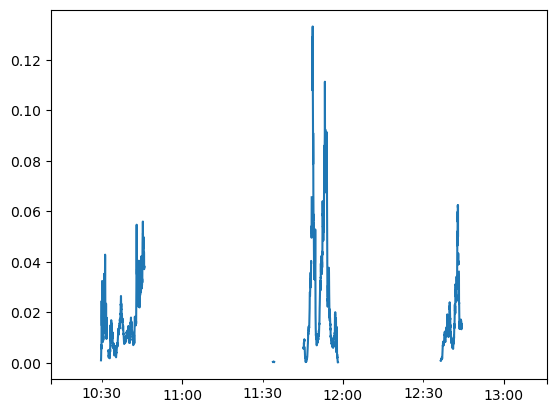

In [14]:
precipitation_rate["r_norris"].plot()

In [ ]:
radar_precip_rate=precipitation_rate.copy()
radar_precip_rate["mean_snow"]=precipitation_rate["mean_snow"]
radar_precip_rate["mean_rain"]=precipitation_rate["mean_rain"]
radar_precip_rate=radar_precip_rate.fillna(0)
radar_precip_rate["rate"]=radar_precip_rate["mean_snow"]+radar_precip_rate["mean_rain"]

# Radar sensitivity study

In [38]:
do_sensitivity_study=True
if do_sensitivity_study:
    # Create higher radar reflectivities 
    strong_radar=processed_radar.copy()
    # Add 4 dBZ that can be expected due to radar attentuation (gaseous and hydrometeor)
    strong_radar["dBZg"]=strong_radar["dBZg"]+4 
    strong_radar["Zg"]=10**(1/10*strong_radar["dBZg"])
    #processed_radar["Zg"][:,4].plot()
    #strong_radar["Zg"][:,4].plot()
    strong_z_series_dict={}
    strong_z_series_dict["zg"]=pd.DataFrame(strong_radar["Zg"][:,4],
                                            index=pd.DatetimeIndex(np.array(strong_radar["Zg"].time[:])))
    #calculate precipitation rate for stronger z
    strong_precip_rate=Radar_cls.take_correct_precipitation_rates(strong_z_series_dict,surface_mask,
                                                    precip_type_series,
                                                    z_for_snow=reflectivity_for_snow)
    strong_precip_rate=strong_precip_rate.fillna(0)
    strong_precip_rate["rate"]=strong_precip_rate["mean_snow"]+strong_precip_rate["mean_rain"]

In [39]:
Radar_Plots=halodataplot.Radar_Quicklook(cfg_dict)
Radar_Plots.processed_radar=processed_radar
Radar_Plots.flight=flight
Radar_Plots.plot_path=plot_path
if do_plotting:
    radar_str=Radar_Plots.processed_radar_rain_rate(halo_era5,halo_icon_hmp,
                                  precipitation_rate,inflow_times,
                                  internal_times,outflow_times,ar_of_day,
                                  calibrated_radar=True,
                                  reflectivity_for_snow=reflectivity_for_snow)

In [40]:
if do_plotting:
    Radar_Plots.plot_only_precip_rates(halo_era5,halo_icon_hmp,
                               precipitation_rate,ar_of_day,
                               inflow_times,internal_times,outflow_times,
                               radar_str,reflectivity_for_snow=reflectivity_for_snow)

In [41]:
# load hydrometeor ICON files for precipitation
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
        central_hour="12"
    else:
        central_hour="14"
elif flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
        central_hour="12"
    else:
        central_hour="13"
hydro_fpath=major_work_path+campaign+"/data/ICON_LEM_2km/"+flight[0]+"/"
hydro_file="Hydrometeor_ICON_"+flight[0]+"_"+ar_of_day+"_"+central_hour+"UTC.nc"
hydro_ds=xr.open_dataset(hydro_fpath+hydro_file)

In [42]:
temp_clat=np.rad2deg(pd.Series(hydro_ds.clat))
cutted_clat=temp_clat[temp_clat.between(halo_df["latitude"].min(),halo_df["latitude"].max())]
temp_clon=np.rad2deg(pd.Series(hydro_ds.clon))
temp_clon=temp_clon.loc[cutted_clat.index]
cutted_clon=temp_clon[temp_clon.between(halo_df["longitude"].min(),halo_df["longitude"].max())]
cutted_icon_precip=hydro_ds["hourly_prec"].isel(
                                ncells=cutted_clon.index)

precip_icon_series=pd.DataFrame(data=np.array(cutted_icon_precip.values[0,:]))

## Precipitation Statistics Distribution

#### Precip rate spatial representativeness

In [43]:
# Entire statistics
if do_plotting:
    rain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                             flight,ar_of_day,"")

In [44]:
# conditional statistics
if do_plotting:
    rain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                             flight,ar_of_day,"",conditional_dist=True)

#### Boxplot Precip rate comparison (log-scale for rates)

In [45]:
if do_plotting:
    boxplot_precip_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate)
#radar_precip_rate

## Dropsonde sector location

In [46]:
#Dropsondes
take_arbitary=False
if not "Lat" in [*Dropsondes.keys()]:
    sondes_lon=[[*Dropsondes["reference_lon"].values()][sonde].data[0] \
                    for sonde in range(Dropsondes["IWV"].shape[0])]
                    
    sondes_lat=[[*Dropsondes["reference_lat"].values()][sonde].data[0]\
                    for sonde in range(Dropsondes["IWV"].shape[0])]
    Dropsondes["Lat"]=pd.Series(data=np.array(sondes_lat),
                                                index=Dropsondes["IWV"].index)
    Dropsondes["Lon"]=pd.Series(data=np.array(sondes_lon),
                                                index=Dropsondes["IWV"].index)

sonde_times_series=pd.Series(index=Dropsondes["IWV"].index.values,data=range(Dropsondes["IWV"].shape[0]))
relevant_sondes_dict={}

if take_arbitary:
    for sector in ["warm_sector","core","cold_sector","internal"]:
        print("Analyse frontal sector ",sector)
        AR_sector_in                       = AR_inflow["AR_inflow_"+sector]
        AR_sector_out                      = AR_outflow["AR_outflow_"+sector]
        
        relevant_sondes_dict[sector]       = {}
        relevant_sondes_dict[sector]["in"] = sonde_times_series.loc[AR_sector_in.index[0]:AR_sector_in.index[-1]]
        relevant_sondes_dict[sector]["out"]= sonde_times_series.loc[AR_sector_out.index[0]:AR_sector_out.index[-1]]
else:
    if flight[0]=="RF05":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,3,9,10,11,12]
            relevant_cold_sector_sondes=[4,5,6]
            relevant_internal_sondes=[7,8,13,14]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
            relevant_sondes_dict["internal"]           = sonde_times_series.iloc[relevant_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[9,10,11,12,15,16,17,18]
            relevant_cold_sector_sondes=[19,20,21]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[4::]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[0:4]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = pd.Series()#sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes]
    
    if flight[0]=="RF06":
        if ar_of_day=="AR_entire_1":
            relevant_warm_sector_sondes=[0,1,2,8,9,10]
            relevant_cold_sector_sondes=[3,4,5,10,11,12]
            relevant_warm_internal_sondes=[7,22]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:3]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[3:]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3:]]
            relevant_sondes_dict["internal"]           = sonde_times_series.iloc[relevant_warm_internal_sondes]
        elif ar_of_day=="AR_entire_2":
            relevant_warm_sector_sondes=[8,9,16,17]
            relevant_cold_sector_sondes=[10,11,12,18,19]
            relevant_warm_internal_sondes=[]
            relevant_sondes_dict["warm_sector"]        = {}
            relevant_sondes_dict["warm_sector"]["in"]  = sonde_times_series.iloc[relevant_warm_sector_sondes[0:2]]
            relevant_sondes_dict["warm_sector"]["out"] = sonde_times_series.iloc[relevant_warm_sector_sondes[2::]]
            relevant_sondes_dict["cold_sector"]        = {}
            relevant_sondes_dict["cold_sector"]["in"]  = sonde_times_series.iloc[relevant_cold_sector_sondes[0:3]]
            relevant_sondes_dict["cold_sector"]["out"] = sonde_times_series.iloc[relevant_cold_sector_sondes[3::]]
# -----> Location information to define the ICON rectangle box around that considers internal precipitation
### Cold sector sondes
#{'cold':                       Halo_Lat   Halo_Lon             dx             dy
# 2022-03-15 10:49:06  72.492348  -9.048471   18458.090409 -252652.694003
# 2022-03-15 10:55:47  72.644676 -11.746952  -68593.693059 -235814.302585
# 2022-03-15 11:03:29  72.776390 -14.936958 -170872.503778 -221254.651706
# 2022-03-15 12:55:00  76.801040  -4.658210  203077.456609  223630.119711
# 2022-03-15 13:05:00  76.952997  -9.839518   74207.822114  240427.441735
# 2022-03-15 13:15:00  77.000370 -15.085639  -56277.172294  245664.086848


# Warm sector sondes
#{'warm':                       Halo_Lat  Halo_Lon             dx             dy
# 2022-03-15 10:19:22  71.412415  2.119259   57426.540578 -294932.867661
# 2022-03-15 10:28:33  71.809677 -1.153413  -57855.149678 -251019.462814
# 2022-03-15 10:34:37  72.042000 -3.403830 -134599.374441 -225338.512344
# 2022-03-15 10:41:45  72.284691 -6.153736 -226219.905006 -198511.444778
# 2022-03-15 12:28:34  75.933517  8.080936  200865.746408  204829.847488
# 2022-03-15 12:36:29  76.259956  4.442734   99695.073834  240914.403915
## 2022-03-15 12:40:08  76.391243  2.720047   53472.408266  255426.827011
# 2022-03-15 12:43:47  76.510696  0.962272    7214.660040  268631.209183}
#{'warm':                       Halo_Lat   Halo_Lon             dx             dy
        # 2022-03-16 10:46:57  71.144676  17.200075   90276.849633 -115494.138234
        # 2022-03-16 10:56:15  71.200279  13.740361  -35595.821300 -109347.779592
        # 2022-03-16 11:03:35  71.197830  11.011759 -133432.507410 -109618.495992
        # 2022-03-16 12:13:00  72.973465  21.382162  168456.503395   86660.171000
        # 2022-03-16 12:21:11  73.190468  18.015015   51433.721131  110647.668101
        # 2022-03-16 12:35:11  73.430244  12.202295 -141138.745448  137152.574717}
        
warm_lon_min_max=[0,0]
warm_lat_min_max=[0,0]

In [47]:
radar_precip_rate["lat"]=halo_df["latitude"].loc[radar_precip_rate.index]
radar_precip_rate["lon"]=halo_df["longitude"].loc[radar_precip_rate.index]#

In [48]:
# radar sector
if flight[0]=="RF05":
    if ar_of_day=="AR_entire_1":
        # old
        #warm_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(71.412415,76.510696)]
        #warm_radar_rain=warm_radar_rain.loc[warm_radar_rain["lon"].between(-6.153736,8.080936)]
        # new
        max_warm_lat=76.510696
        max_warm_lon=10.080936
        min_warm_lat=70.412415
        min_warm_lon=-6.153736
        
        
        #cold_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(72.492348,77.000370)]
        #cold_radar_rain=radar_precip_rate.loc[radar_precip_rate["lon"].between(-15.085639,-4.658210)]
    elif ar_of_day=="AR_entire_2":
        max_warm_lat=76.510696
        max_warm_lon=8.080936
        min_warm_lat=72.850830
        min_warm_lon=-4.379189
    else:
        Exception("no other AR sector defined")# apply sector to icon

elif flight[0]=="RF06":
    if ar_of_day=="AR_entire_1":
        max_warm_lat=73.430244
        max_warm_lon=21.382162
        min_warm_lat=71.144676
        min_warm_lon=11.011759
        
    elif ar_of_day=="AR_entire_2":
        max_warm_lat=75.811005
        max_warm_lon=25.683155
        min_warm_lat=72.973465
        min_warm_lon=18.015015
        
warm_radar_rain=radar_precip_rate.loc[radar_precip_rate["lat"].between(min_warm_lat,max_warm_lat)]
warm_radar_rain=warm_radar_rain.loc[warm_radar_rain["lon"].between(min_warm_lon,max_warm_lon)]        

warm_icon_rain=halo_icon_hmp.loc[warm_radar_rain.index]
warm_icon_rain["rate"]=warm_icon_rain["Interp_Precip"]
try:
    cold_icon_rain=halo_icon_hmp.loc[cold_radar_rain.index]
    cold_icon_rain["rate"]=cold_icon_rain["Interp_Precip"]
except:
    print("No cold sector available")


No cold sector available


<xarray.DataArray 'time' ()>
array('2022-03-15T12:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2022-03-15T12:00:00
Figure saved as  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1_warm_Map_box_precipitation
Figure saved as  C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\my_GIT\HALO_AC3_AR_Budget_Closure\notebooks/../plots/RF05_AR_entire_1_Warm_Sector_Rain_Rate_Representativeness.png


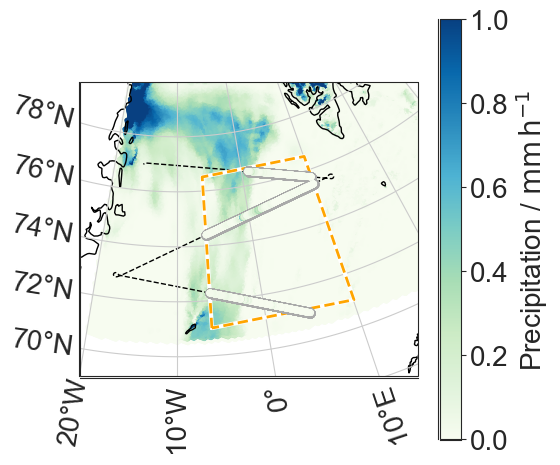

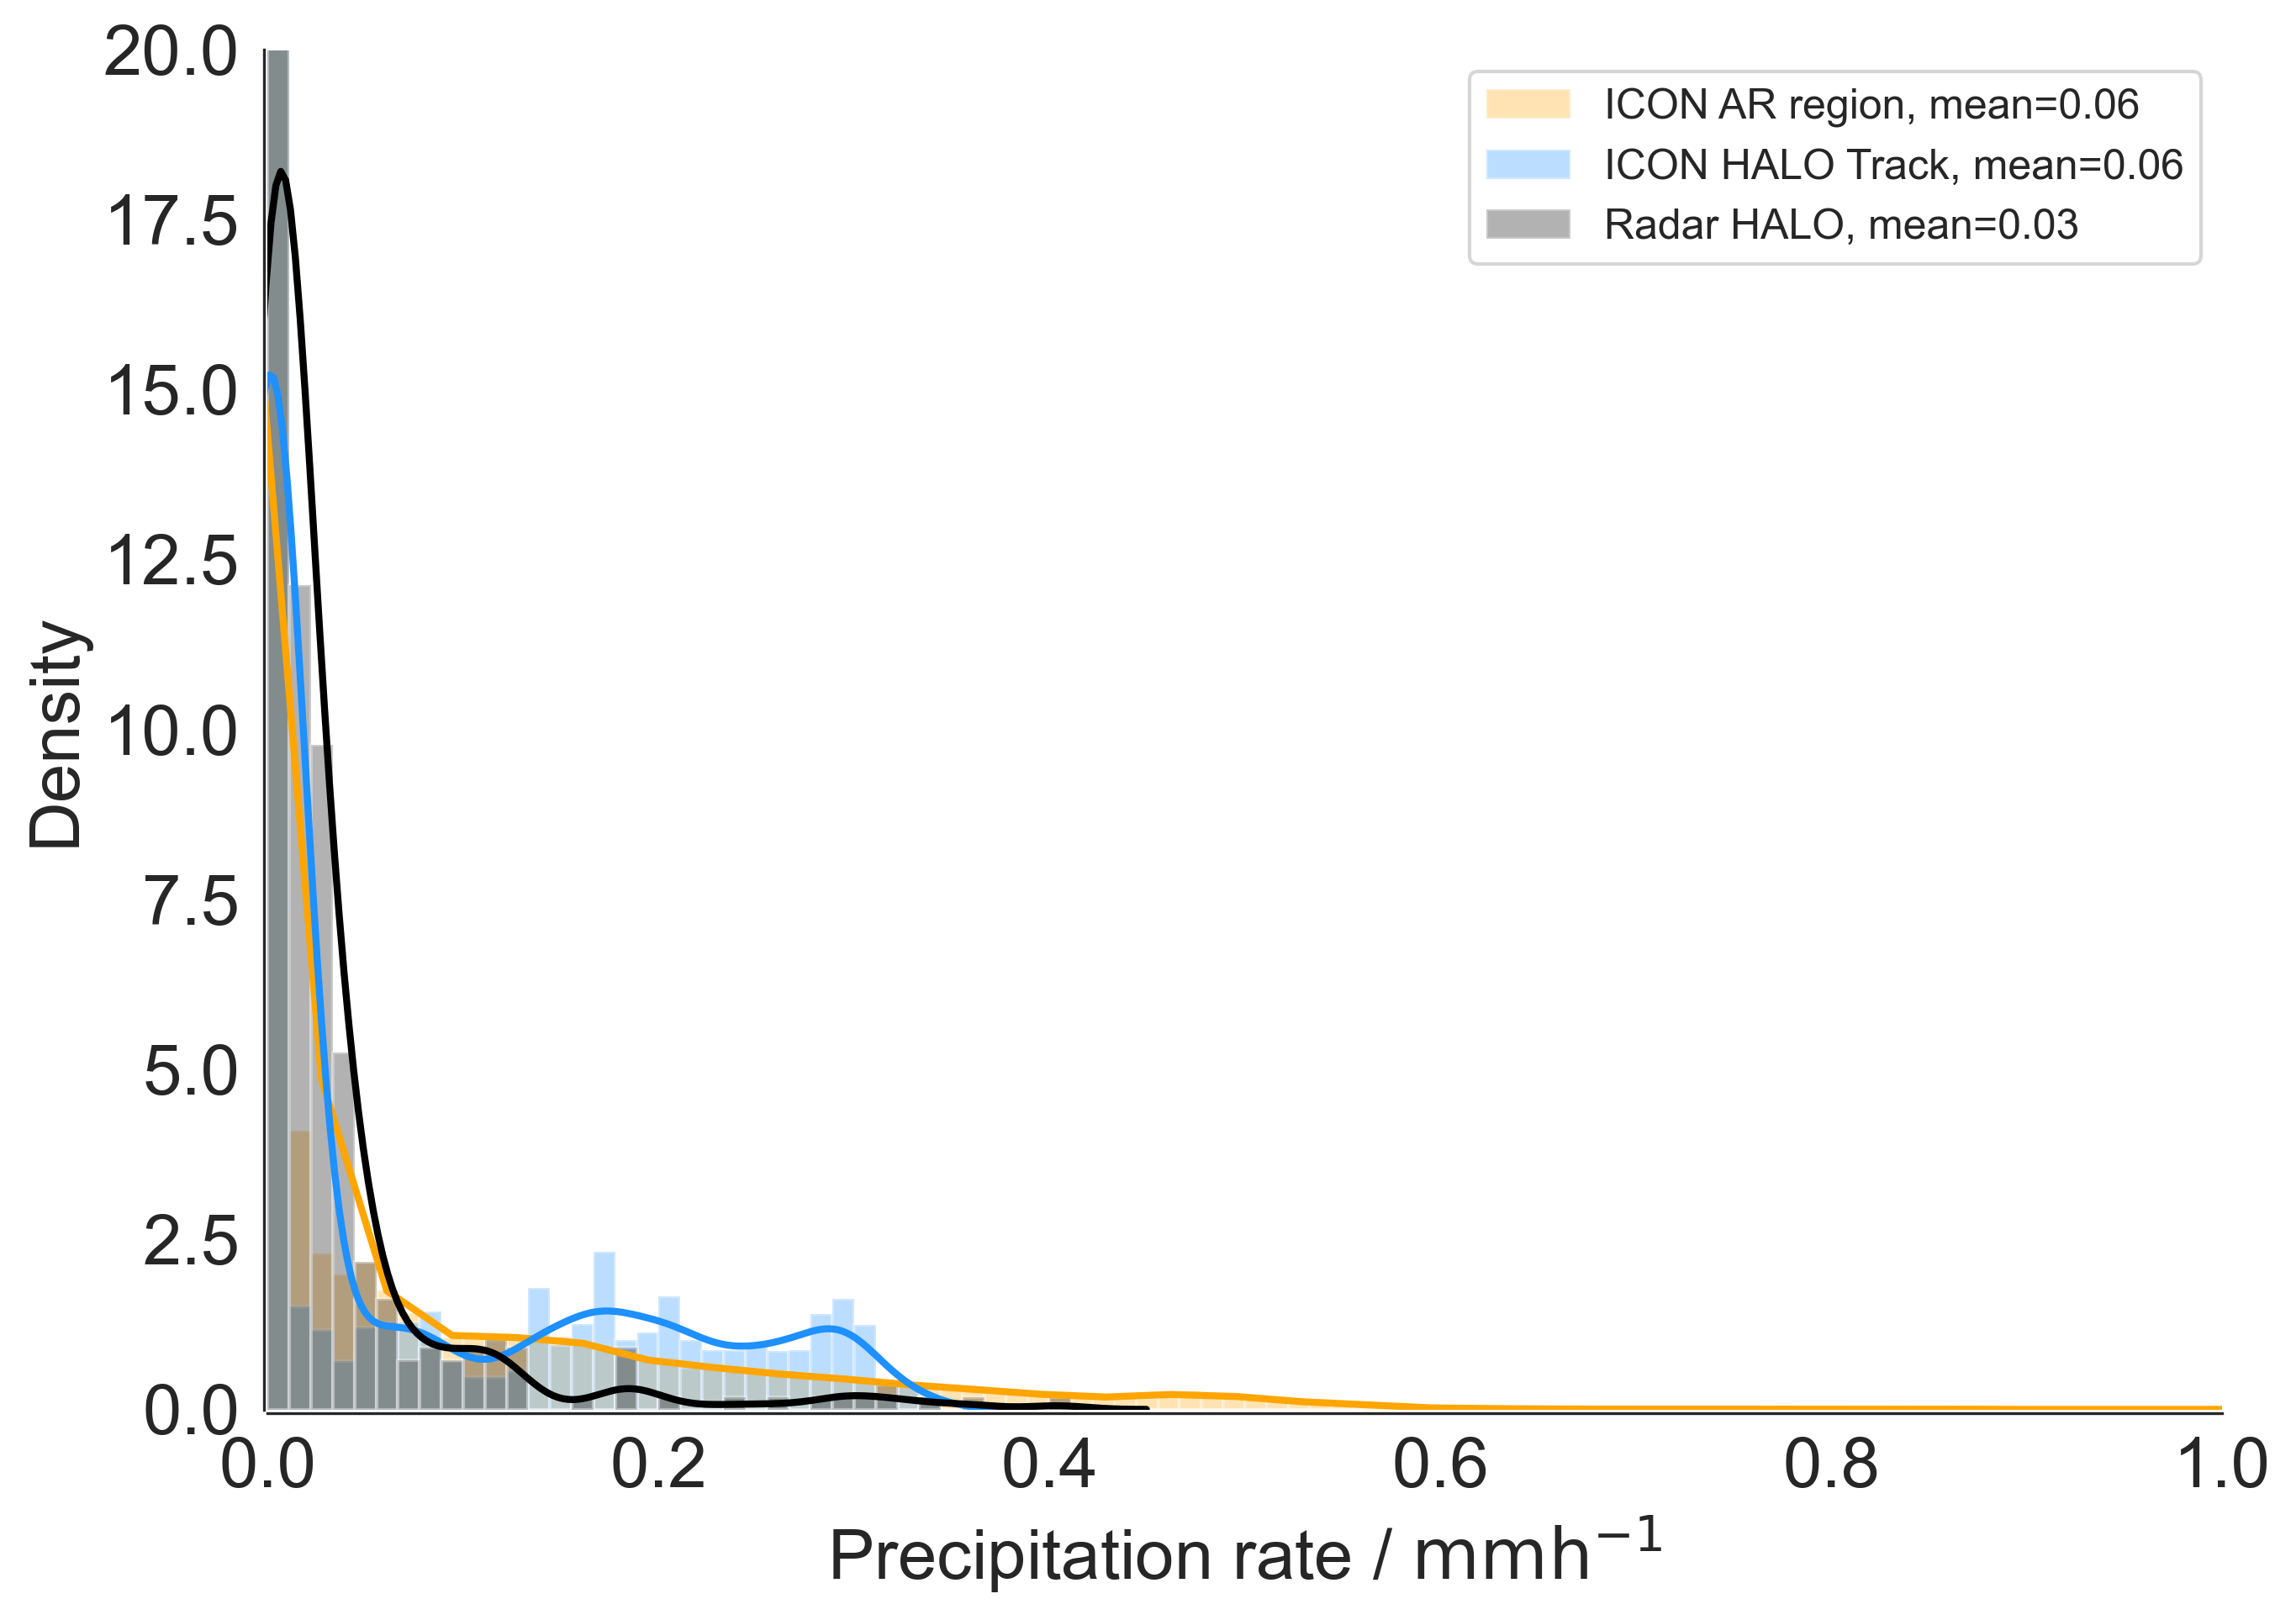

In [62]:
map_precipitation_region(hydro_ds,processed_radar,halo_df,warm_radar_rain,plot_path,sector="warm")

regridded_warm_radar_rain=warm_radar_rain.resample("10s").mean()
regridded_warm_radar_rain=regridded_warm_radar_rain.dropna(subset = ['rate'])
conditional_dist=False
sector_cutted_clat=temp_clat[temp_clat.between(min_warm_lat,max_warm_lat)]
temp_clon=np.rad2deg(pd.Series(hydro_ds.clon))
temp_clon=temp_clon.loc[sector_cutted_clat.index]
sector_cutted_clon=temp_clon[temp_clon.between(min_warm_lon,max_warm_lon)]
sector_cutted_icon_precip=hydro_ds["hourly_prec"].isel(
                                ncells=cutted_clon.index)

sector_precip_icon=pd.DataFrame(data=np.array(cutted_icon_precip.values[0,:]))

import seaborn as sns
sns.set_style("white")
x1 = sector_precip_icon.values
x2 = warm_icon_rain["rate"].values
#x3 = halo_era5["Interp_Precip"]
x4 = regridded_warm_radar_rain["rate"]
#if conditional_dist:
#        x1=x1[x1>0]
#        x2=x2[x2>0]
#        x3=x3[x3>0]
#        x4=x4[x4>0]
# Plot
kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 300)#
#sns.distplot(x3, bins=np.linspace(0,2,91),color="deeppink", label="ERA5 HALO Track", **kwargs)
sns.distplot(x1, bins=np.linspace(0,1,91),color="orange", label="ICON AR region, mean="+str(round(x1.mean(),2)), **kwargs)
sns.distplot(x2, bins=np.linspace(0,1,91),color="dodgerblue", label="ICON HALO Track, mean="+str(round(x2.mean(),2)), **kwargs)
sns.distplot(x4, bins=np.linspace(0,1,91),color="k", label="Radar HALO, mean="+str(round(x4.mean(),2)), **kwargs)
do_sensitivity_study=False
if do_sensitivity_study:
    warm_strong_precip=strong_precip_rate.loc[warm_radar_rain.index]
    warm_strong_precip=warm_strong_precip.loc[warm_radar_rain.index] 
    x5=warm_strong_precip.resample("10s").mean().dropna(subset=["rate"])["rate"]
    sns.distplot(x5, bins=np.linspace(0,1,91),color="indigo", label="Radar HALO +4 dBZ, mean="+str(round(x5.mean(),2)),**kwargs)

plt.ylim(0,20)
plt.xlim(0,1)
#plt.xlim(1e-2,1)
#plt.xscale("log")
if not conditional_dist:
    plt.xlabel("Precipitation rate / $\mathrm{mmh}^{-1}$")
else:
    plt.xlabel("Conditional Precipitation rate / $\mathrm{mmh}^{-1}$")
    
plt.legend(fontsize=12)
file_end=".png"
fig_name="Warm_Sector_Rain_Rate_Representativeness"
if do_sensitivity_study:
    fig_name+="_plus_4dbz"
fig_name+=file_end
if conditional_dist:
    fig_name="Conditional_"+fig_name
fig_name=flight[0]+"_"+ar_of_day+"_"+fig_name
fig_path=plot_path
sns.despine(offset=1)
plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
print("Figure saved as ",fig_path+fig_name)

'\nrain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,\n                                 flight,ar_of_day,sector_to_plot,\n                                conditional_dist=False):\n    import seaborn as sns\n    sns.set_style("white")\n\n    x1 = precip_icon_series.copy()\n    x2 = halo_icon_hmp["Interp_Precip"]\n    x3 = halo_era5["Interp_Precip"]\n    x4 = radar_precip_rate["rate"]\n    \n    if conditional_dist:\n        x1=x1[x1>0]\n        x2=x2[x2>0]\n        x3=x3[x3>0]\n        x4=x4[x4>0]\n    # Plot\n    kwargs = dict(hist_kws={\'alpha\':.3}, kde_kws={\'linewidth\':2})\n\n    plt.figure(figsize=(10,7), dpi= 300)#\n    sns.distplot(x3, bins=np.linspace(0,2,91),color="deeppink", label="ERA5 HALO Track", **kwargs)\n    sns.distplot(x1, bins=np.linspace(0,2,91),color="dodgerblue", label="ICON AR region", **kwargs)\n    sns.distplot(x2, bins=np.linspace(0,2,91),color="orange", label="ICON HALO Track", **kwargs)\n    sns.distplot(x4, bins=np.

In [28]:
#ICON_HALO_AC3=ICON_NWP_HALO_AC3(flight,campaign,ar_sector,add_hydrometeors=add_hydrometeors)
#hydro_ds["hourly_prec"]
if do_plotting:
    boxplot_precip_comparison(pd.Series(data=hydro_ds["hourly_prec"].values[0,:]),
                          halo_icon_hmp.loc[warm_radar_rain.index],halo_era5.loc[warm_radar_rain.index], warm_radar_rain,plot_path)

In [29]:
#describe warm rain rate
warm_precip_file_name="warm_precip_"+flight[0]+"_"+ar_of_day+".csv"
warm_radar_rain.to_csv(precip_rate_path+warm_precip_file_name)
print("Warm rain saved as:",precip_rate_path+warm_precip_file_name)
try:
    cold_precip_file_name="cold_precip_"+flight[0]+"_"+ar_of_day+".csv"
    cold_radar_rain.to_csv(precip_rate_path+cold_precip_file_name)
    print("Cold rain saved as:",precip_rate_path+cold_precip_file_name)
except:
    "No cold sector available"

Warm rain saved as: C:\Users\u300737\Desktop\Desktop_alter_Rechner\PhD_UHH_WIMI\Work\GIT_Repository//HALO_AC3/data/precip_rates/warm_precip_RF05_AR_entire_1.csv


### Rain fraction

In [30]:
## Radar
print("Radar pre-frontal rain fraction:",warm_radar_rain.loc[warm_radar_rain["rate"]>0.0].shape[0]/warm_radar_rain.shape[0])
try:
    print("Radar post-frontal rain fraction:",cold_radar_rain.loc[cold_radar_rain["rate"]>0.0].shape[0]/cold_radar_rain.shape[0])
except:
    print("Radar post-frontal rain fraction not defined")

Radar pre-frontal rain fraction: 0.6859688195991092
Radar post-frontal rain fraction not defined


In [31]:
print("ICON pre-frontal rain fraction:",warm_icon_rain.loc[warm_icon_rain["rate"]>0.0].shape[0]/warm_icon_rain.shape[0])
try:
    print("ICON post-frontal rain fraction:",cold_icon_rain.loc[cold_icon_rain["rate"]>0.0].shape[0]/cold_icon_rain.shape[0])
except:
    print("ICON post-frontal rain fraction not defined")

ICON pre-frontal rain fraction: 0.8839846122696903
ICON post-frontal rain fraction not defined


In [32]:
if do_plotting:
    plot_frontal_sector_radar_icon_rain_comparison(
                    warm_radar_rain,cold_radar_rain,
                    warm_icon_rain,cold_icon_rain,plot_path)

In [33]:
#if do_plotting:
plot_frontal_sector_radar_icon_rain_comparison(
                    warm_radar_rain,cold_radar_rain,
                    warm_icon_rain,cold_icon_rain,plot_path,do_conditional=True)

NameError: name 'cold_radar_rain' is not defined

In [ ]:
#if do_plotting:
#sector_rain_halo_icon_comparison(warm_radar_rain,cold_radar_rain,warm_icon_rain,cold_icon_rain,flight,ar_of_day,sector_to_plot,plot_path)

### 3D Flight Overview

In [ ]:
map_AR_sea_ice(cfg_dict,radar_ds,ds)

In [ ]:
map_3d_radar_view(processed_radar,Dropsondes,plot_path)

In [ ]:
"""
rain_distribution_comparison(precip_icon_series,halo_icon_hmp,halo_era5, radar_precip_rate,
                                 flight,ar_of_day,sector_to_plot,
                                conditional_dist=False):
    import seaborn as sns
    sns.set_style("white")

    x1 = precip_icon_series.copy()
    x2 = halo_icon_hmp["Interp_Precip"]
    x3 = halo_era5["Interp_Precip"]
    x4 = radar_precip_rate["rate"]
    
    if conditional_dist:
        x1=x1[x1>0]
        x2=x2[x2>0]
        x3=x3[x3>0]
        x4=x4[x4>0]
    # Plot
    kwargs = dict(hist_kws={'alpha':.3}, kde_kws={'linewidth':2})

    plt.figure(figsize=(10,7), dpi= 300)#
    sns.distplot(x3, bins=np.linspace(0,2,91),color="deeppink", label="ERA5 HALO Track", **kwargs)
    sns.distplot(x1, bins=np.linspace(0,2,91),color="dodgerblue", label="ICON AR region", **kwargs)
    sns.distplot(x2, bins=np.linspace(0,2,91),color="orange", label="ICON HALO Track", **kwargs)
    sns.distplot(x4, bins=np.linspace(0,2,91),color="k", label="Radar HALO Track", **kwargs)
    plt.ylim(0,50)
    plt.xlim(0,1)
    if not conditional_dist:
        plt.xlabel("Precipitation rate / $\mathrm{mmh}^{-1}$")
    else:
        plt.xlabel("Conditional Precipitation rate / $\mathrm{mmh}^{-1}$")
    
    plt.legend()
    fig_name="Rain_rate_representativeness.png"
    if conditional_dist:
        fig_name="Conditional_"+fig_name
    fig_name=flight[0]+"_"+ar_of_day+"_"+sector_to_plot+"_"+fig_name
    fig_path=plot_path
    sns.despine(offset=1)
    plt.savefig(fig_path+fig_name,dpi=300,bbox_inches="tight")
    print("Figure saved as ",fig_path+fig_name)
"""